In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/dataset/Pascal_VOC/cache/

/content/drive/MyDrive/dataset/Pascal_VOC/cache


In [3]:
!ls

abstract50S		    abstract_targets.npy      pascal_annots.npy
abstract_annots_concat.npy  model1.h5		      pascal_images.npy
abstract_annots.npy	    pascal50S		      pascal_targets.npy
abstract_images.npy	    pascal_annots_concat.npy


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
labels = np.array(['person', 'bird', 'cat', 'cow', 'dog', 'horse',
              'sheep', 'aeroplane', 'bicycle', 'boat', 'bus', 'car',
              'motorbike', 'train', 'bottle', 'chair', 'dining table',
              'potted plant', 'sofa', 'tv/monitor'])

In [6]:
abstract_images = np.load('abstract_images.npy')
abstract_targets = np.load('abstract_targets.npy')

pascal_images = np.load('pascal_images.npy', allow_pickle=True)
pascal_targets = np.load('pascal_targets.npy')

array(['person', 'cat'], dtype='<U12')

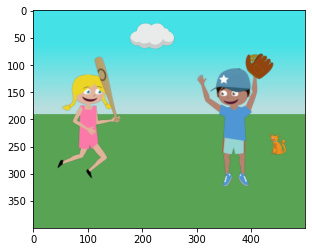

In [7]:
index = 0
plt.imshow(abstract_images[index])
labels[abstract_targets[index] == 1]

array(['person', 'boat'], dtype='<U12')

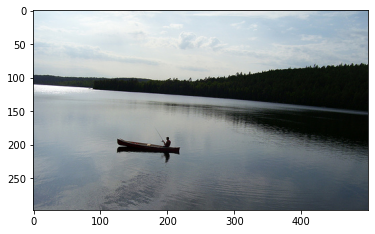

In [8]:
index = 0
plt.imshow(pascal_images[index])
labels[pascal_targets[index] == 1]

In [9]:
abstract_images = abstract_images[:, :, :, :3]

In [10]:
import cv2

In [11]:
def resizing(images):
  temp = []
  for image in images:
    resized = cv2.resize(image, (250, 200), interpolation=cv2.INTER_AREA)
    temp.append(resized)

  images = np.array(temp)
  return images

In [12]:
abstract_images = resizing(abstract_images)

In [13]:
pascal_images = resizing(pascal_images)

In [14]:
pascal_images = pascal_images / 255

In [15]:
images = np.concatenate((pascal_images, abstract_images), axis=0)

In [16]:
targets = np.concatenate((pascal_targets, abstract_targets), axis=0)

In [17]:
class_weights = np.sum(targets, axis=0)
class_weights = dict(zip(range(20), class_weights))

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(images, targets, test_size=0.15)

In [20]:
from tensorflow import keras
from keras.applications import VGG16
from keras import layers

In [21]:
def get_model():
  model = keras.models.Sequential()
  model.add(layers.Conv2D(input_shape=(images.shape[1],images.shape[2],3),filters=128,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(layers.BatchNormalization())

  model.add(layers.Conv2D(filters=128, kernel_size=(2,2), padding="same", activation="relu"))
  model.add(layers.BatchNormalization())

  model.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))

  model.add(layers.Conv2D(filters=64, kernel_size=(2,2), padding="same", activation="relu"))
  model.add(layers.BatchNormalization())

  model.add(layers.Conv2D(filters=64, kernel_size=(2,2), padding="same", activation="relu"))
  model.add(layers.BatchNormalization())

  model.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2), name='MP_2'))

  model.add(layers.Conv2D(filters=32, kernel_size=(2,2), padding="same", activation="relu"))
  model.add(layers.BatchNormalization())

  model.add(layers.Conv2D(filters=32, kernel_size=(2,2), padding="same", activation="relu", name='last_conv'))
  model.add(layers.BatchNormalization())
  headModel = model.output
  headModel = layers.Flatten()(headModel)
  headModel = layers.Dropout(rate=0.1)(headModel)

  headModel = layers.Dense(64, activation='relu')(headModel)
  headModel = layers.Dense(64, activation='relu')(headModel)
  headModel = layers.Dense(len(labels), activation='sigmoid')(headModel)
  model = keras.models.Model(inputs=model.input, outputs=headModel)
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model

In [22]:
# session crashed
# def vgg16Model():
#     baseModel = VGG16(weights="imagenet",
#                       include_top=False,
#                       input_tensor=layers.Input(shape=(400, 500, 3)))
#     headModel = baseModel.output
#     headModel = layers.Flatten(name="flatten")(headModel)
#     headModel = layers.Dense(128, activation='relu')(headModel)
#     headModel = layers.BatchNormalization()(headModel)
#     headModel = layers.Dense(128, activation='relu')(headModel)
#     headModel = layers.BatchNormalization()(headModel)
#     headModel = layers.Dense(64, activation='relu')(headModel)
#     headModel = layers.BatchNormalization()(headModel)
#     headModel = layers.Dense(len(labels), activation="sigmoid")(headModel)

#     model = keras.models.Model(inputs=baseModel.input, outputs=headModel)
#     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
#     return model

In [23]:
model = get_model()

In [24]:
es = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
cp = keras.callbacks.ModelCheckpoint('model1.h5', save_best_only=True)

In [25]:
model.fit(X_train, y_train, epochs=15, validation_data=(X_test, y_test), batch_size=32, callbacks=[es, cp], class_weight=class_weights)

Epoch 1/15
43/43 [==============================] - 62s 543ms/step - loss: 1113.5857 - accuracy: 0.2423 - val_loss: 0.4950 - val_accuracy: 0.9667
Epoch 2/15
43/43 [==============================] - 19s 445ms/step - loss: 355.5690 - accuracy: 0.9813 - val_loss: 0.5116 - val_accuracy: 0.3467
Epoch 3/15
43/43 [==============================] - 19s 450ms/step - loss: 270.0440 - accuracy: 0.9905 - val_loss: 0.4502 - val_accuracy: 0.1800
Epoch 4/15
43/43 [==============================] - 19s 453ms/step - loss: 197.4749 - accuracy: 0.9923 - val_loss: 0.4441 - val_accuracy: 0.3800
Epoch 5/15
43/43 [==============================] - 20s 458ms/step - loss: 153.6496 - accuracy: 0.9862 - val_loss: 0.5213 - val_accuracy: 0.3733
Epoch 6/15
43/43 [==============================] - 20s 463ms/step - loss: 120.3171 - accuracy: 0.9954 - val_loss: 0.4951 - val_accuracy: 0.0467
Epoch 7/15
43/43 [==============================] - 20s 469ms/step - loss: 89.3704 - accuracy: 0.9846 - val_loss: 0.4236 - val_ac

In [26]:
model.evaluate(X_test, y_test)

5/5 [==============================] - 1s 105ms/step - loss: 0.3804 - accuracy: 1.0000


[0.3803882598876953, 1.0]

In [27]:
preds = (model.predict(images) > 0.5) * 1

In [28]:
from sklearn.metrics import f1_score

In [30]:
f1_score(targets, preds, average='weighted')

0.9407251766606567

In [34]:
np.sum(preds, axis=0)

array([1499,   75,  122,   53,  228,   54,   52,  103,   61,   68,   51,
        113,  103,   56,   33,  123,  213,   60,   70,   59])

In [31]:
dict(zip(labels, np.sum(preds, axis=0)))

{'aeroplane': 103,
 'bicycle': 61,
 'bird': 75,
 'boat': 68,
 'bottle': 33,
 'bus': 51,
 'car': 113,
 'cat': 122,
 'chair': 123,
 'cow': 53,
 'dining table': 213,
 'dog': 228,
 'horse': 54,
 'motorbike': 103,
 'person': 1499,
 'potted plant': 60,
 'sheep': 52,
 'sofa': 70,
 'train': 56,
 'tv/monitor': 59}

In [33]:
dict(zip(labels, np.sum(targets, axis=0)))

{'aeroplane': 111,
 'bicycle': 62,
 'bird': 75,
 'boat': 58,
 'bottle': 68,
 'bus': 63,
 'car': 135,
 'cat': 129,
 'chair': 125,
 'cow': 59,
 'dining table': 243,
 'dog': 244,
 'horse': 60,
 'motorbike': 108,
 'person': 1500,
 'potted plant': 62,
 'sheep': 57,
 'sofa': 74,
 'train': 65,
 'tv/monitor': 66}